In [10]:
import osmium
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt

# Define a class to extract ways (roads) from OSM file
class RoadHandler(osmium.SimpleHandler):
    def __init__(self):
        super().__init__()
        self.ways = []

    def way(self, w):
        if 'highway' in w.tags:
            self.ways.append({
                'id': w.id,
                'highway': w.tags.get('highway', 'unknown'),
                'name': w.tags.get('name', 'Unnamed Road')
            })

# Parse the OSM file
osm_file = "map.osm"
handler = RoadHandler()
handler.apply_file(osm_file)

# Convert to DataFrame
import pandas as pd
roads_df = pd.DataFrame(handler.ways)

# Display basic road statistics
print("🚗 Road Type Distribution:\n", roads_df["highway"].value_counts())


🚗 Road Type Distribution:
 residential       3243
service            233
tertiary           207
secondary          167
primary            137
unclassified       108
trunk               88
living_street       69
trunk_link          19
track               18
primary_link         8
path                 7
secondary_link       5
footway              5
construction         3
road                 1
Name: highway, dtype: int64


In [11]:
import osmnx as ox
import networkx as nx

# Load OSM as a graph
graph = ox.graph_from_xml("map.osm", simplify=True)

# Convert graph to GeoDataFrames (nodes & edges)
nodes, edges = ox.graph_to_gdfs(graph)

# Save edges for analysis
edges.to_file("road_network.geojson", driver="GeoJSON")

print("✅ Graph Loaded: ", graph)
print("📌 Number of Nodes:", len(nodes))
print("📌 Number of Edges:", len(edges))


✅ Graph Loaded:  MultiDiGraph with 6849 nodes and 17112 edges
📌 Number of Nodes: 6849
📌 Number of Edges: 17112


Missing Road Names: 0
Invalid Coordinates: True    6849
Name: valid_coords, dtype: int64


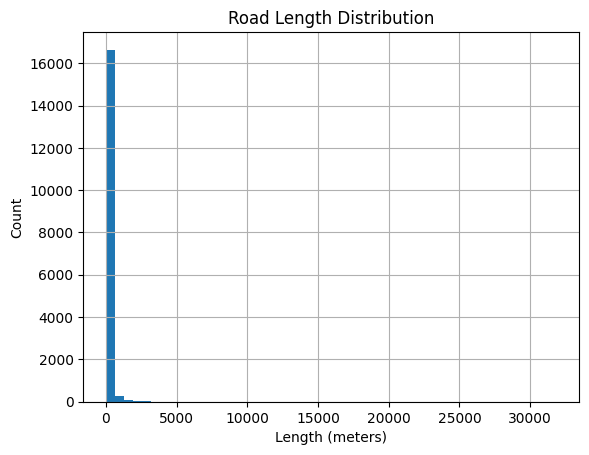

In [12]:
# Check for missing values
print("Missing Road Names:", roads_df['name'].isna().sum())

# Check coordinate validity
nodes["valid_coords"] = nodes.apply(lambda row: (-180 <= row["x"] <= 180) and (-90 <= row["y"] <= 90), axis=1)
print("Invalid Coordinates:", nodes["valid_coords"].value_counts())

# Road length distribution
edges["length"].hist(bins=50)
plt.title("Road Length Distribution")
plt.xlabel("Length (meters)")
plt.ylabel("Count")
plt.show()


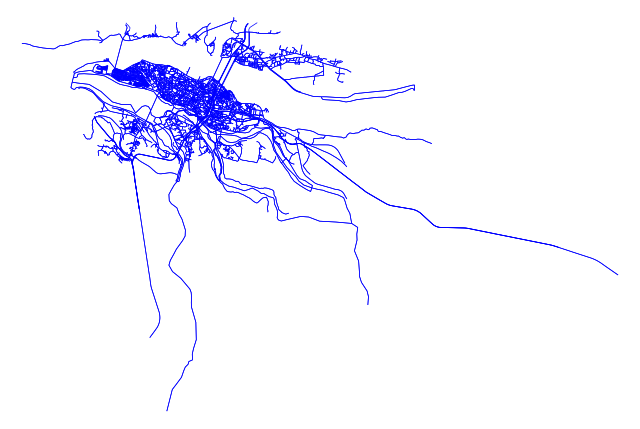

In [13]:
fig, ax = ox.plot_graph(graph, node_size=0, edge_color="blue", edge_linewidth=0.5, bgcolor="white") #plot road nework


In [15]:
import folium
from folium.plugins import HeatMap

# Convert nodes to Folium-compatible format
m = folium.Map(location=[nodes["y"].mean(), nodes["x"].mean()], zoom_start=12)
heat_data = [[row["y"], row["x"]] for index, row in nodes.iterrows()]
HeatMap(heat_data).add_to(m) # road ddensity heatmap

# Save map
m.save("road_density_heatmap.html")


C:\Users\rudra\AppData\Local\Temp\ipykernel_15868\655247873.py:8: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  edges_gdf[edges_gdf["highway"] == "motorway"].plot(ax=ax, color="red", linewidth=1, label="Motorways")


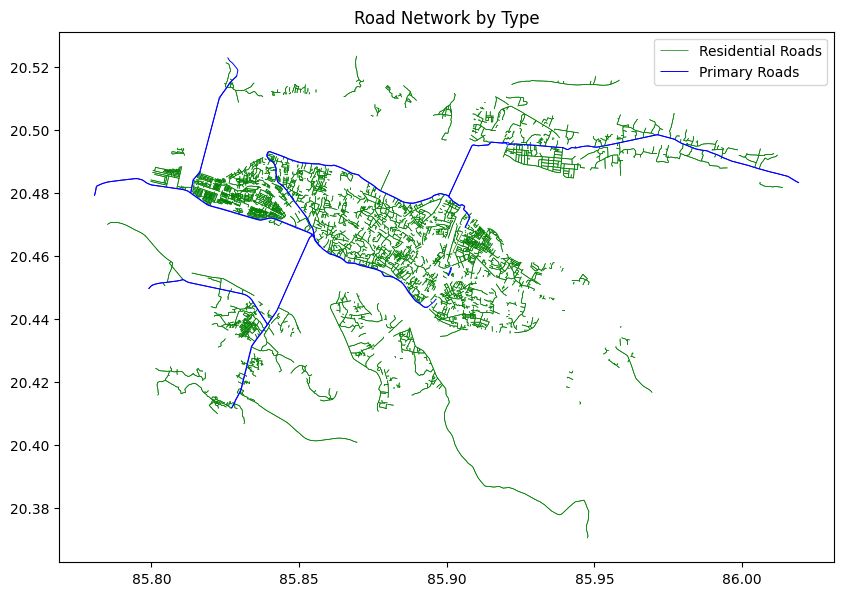

In [16]:
import geopandas as gpd

# Convert edges to GeoDataFrame
edges_gdf = gpd.GeoDataFrame(edges, geometry="geometry", crs="EPSG:4326")

# Plot different road types
fig, ax = plt.subplots(figsize=(10, 10))
edges_gdf[edges_gdf["highway"] == "motorway"].plot(ax=ax, color="red", linewidth=1, label="Motorways")
edges_gdf[edges_gdf["highway"] == "residential"].plot(ax=ax, color="green", linewidth=0.5, label="Residential Roads")
edges_gdf[edges_gdf["highway"] == "primary"].plot(ax=ax, color="blue", linewidth=0.7, label="Primary Roads")

plt.legend()
plt.title("Road Network by Type")
plt.show()


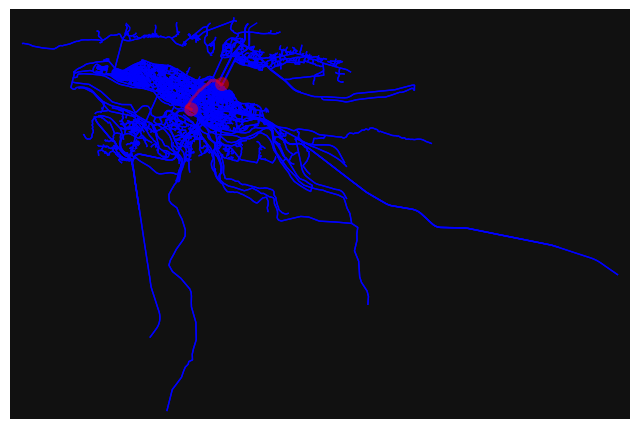

In [17]:
orig = ox.distance.nearest_nodes(graph, 85.88, 20.45)  # Example start point
dest = ox.distance.nearest_nodes(graph, 85.91, 20.48)  # Example end point

route = nx.shortest_path(graph, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(graph, route, node_size=0, edge_color="blue", edge_linewidth=1, route_color="red", route_linewidth=2)


In [ ]:

import networkx as nx

# Compute betweenness centrality (important roads)
centrality = nx.betweenness_centrality(graph, weight="length", normalized=True)
nx.set_edge_attributes(graph, centrality, "centrality")

# Extract top 10 important roads
top_central_roads = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
#print("🛣 Most Important Roads:", top_central_roads)

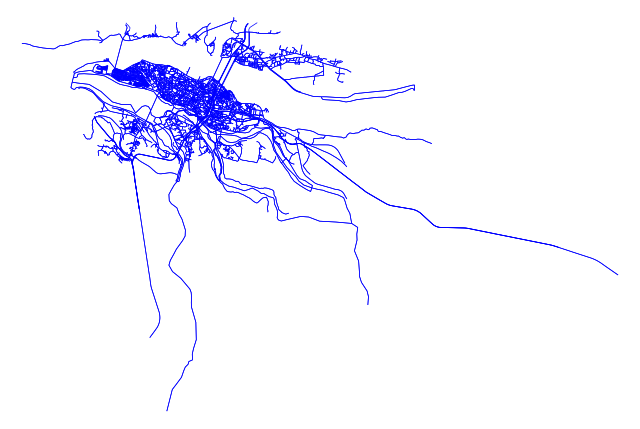

<Figure size 640x480 with 0 Axes>

In [19]:
fig, ax = ox.plot_graph(graph, node_size=0, edge_color="blue", edge_linewidth=0.5, bgcolor="white")
plt.savefig("road_network.png", dpi=300)
plt.show()


In [22]:
import osmium
from shapely.geometry import Polygon
import geopandas as gpd

# Handler to store node locations
class NodeStoreHandler(osmium.SimpleHandler):
    def __init__(self):
        super().__init__()
        self.nodes = {}

    def node(self, n):
        self.nodes[n.id] = (n.location.lon, n.location.lat)

# Handler to extract building data
class BuildingHandler(osmium.SimpleHandler):
    def __init__(self, node_store):
        super().__init__()
        self.node_store = node_store
        self.buildings = []

    def way(self, w):
        if "building" in w.tags:
            # Access node coordinates directly using the node ref
            nodes = [self.node_store.nodes[n.ref] for n in w.nodes if n.ref in self.node_store.nodes]
            if len(nodes) > 2:  # Ensure it's a closed shape
                self.buildings.append(Polygon(nodes))

# First, store node locations
node_handler = NodeStoreHandler()
node_handler.apply_file("map.osm", locations=True)

# Then, process ways using stored nodes
b_handler = BuildingHandler(node_handler)
b_handler.apply_file("map.osm")

# Convert to GeoDataFrame
buildings_gdf = gpd.GeoDataFrame(geometry=b_handler.buildings, crs="EPSG:4326")
buildings_gdf.to_file("buildings.geojson", driver="GeoJSON")

print("🏢 Extracted Buildings:", len(buildings_gdf))


🏢 Extracted Buildings: 644


c:\Users\rudra\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


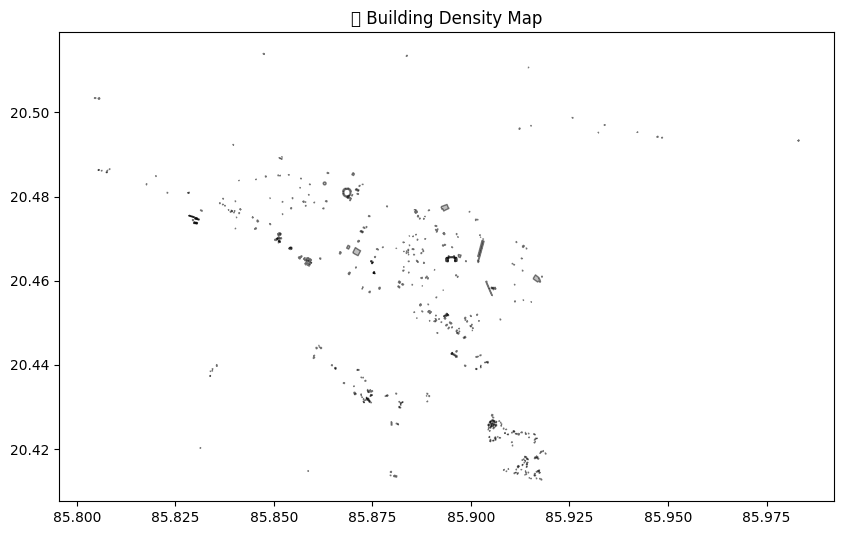

In [23]:
import matplotlib.pyplot as plt

# Plot building density
fig, ax = plt.subplots(figsize=(10, 10))
buildings_gdf.plot(ax=ax, color="gray", alpha=0.5, edgecolor="black")
plt.title("🏢 Building Density Map")
plt.show()


c:\Users\rudra\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


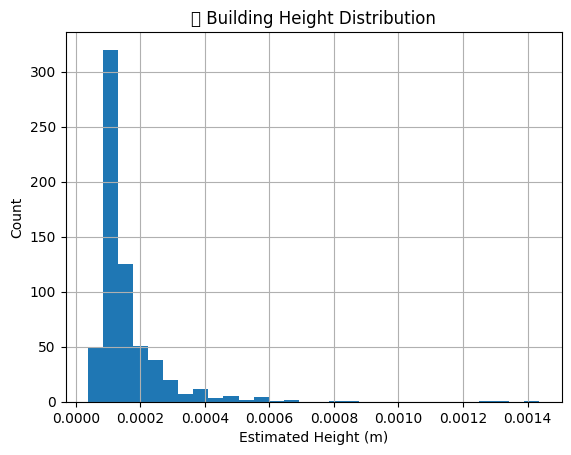

In [24]:
# Extract height if available
import pandas as pd

buildings_gdf["height"] = buildings_gdf["geometry"].apply(lambda x: x.area**0.5 if x.area else None)
buildings_gdf["height"].hist(bins=30)
plt.xlabel("Estimated Height (m)")
plt.ylabel("Count")
plt.title("🏢 Building Height Distribution")
plt.show()


In [25]:
class POIHandler(osmium.SimpleHandler):
    def __init__(self):
        super().__init__()
        self.pois = []

    def node(self, n):
        if "amenity" in n.tags:
            self.pois.append({
                "amenity": n.tags["amenity"],
                "name": n.tags.get("name", "Unknown"),
                "lat": n.location.lat,
                "lon": n.location.lon
            })

poi_handler = POIHandler()
poi_handler.apply_file("map.osm")

# Convert to DataFrame
pois_df = pd.DataFrame(poi_handler.pois)

# Count amenities
print("📍 POI Count by Category:\n", pois_df["amenity"].value_counts())


📍 POI Count by Category:
 hospital            84
clinic              33
place_of_worship    21
doctors             14
restaurant          13
cafe                10
bank                10
school               6
atm                  6
fast_food            6
cinema               4
fuel                 4
college              4
police               3
bus_station          2
blood_bank           2
dentist              2
fountain             1
courthouse           1
parking_space        1
university           1
Name: amenity, dtype: int64


In [26]:
import folium
from folium.plugins import HeatMap

# Create map
m = folium.Map(location=[pois_df["lat"].mean(), pois_df["lon"].mean()], zoom_start=12)

# Add POIs as heatmap
heat_data = [[row["lat"], row["lon"]] for _, row in pois_df.iterrows()]
HeatMap(heat_data).add_to(m)

# Save as HTML
m.save("poi_density_map.html")


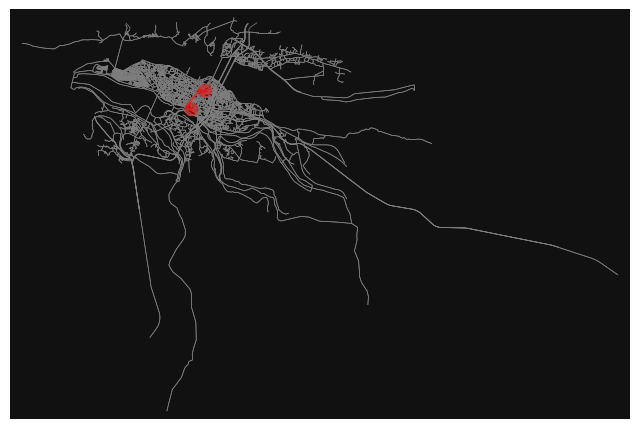

c:\Users\rudra\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


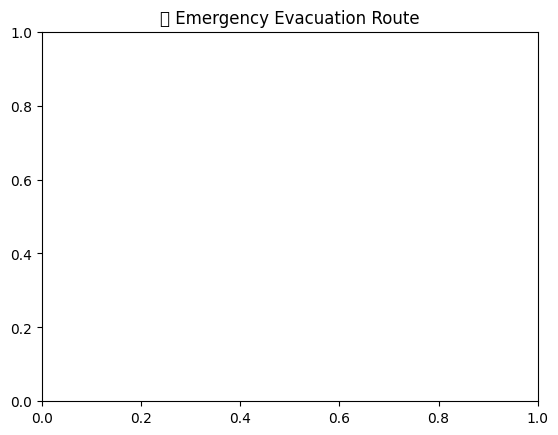

In [28]:
import networkx as nx
import osmnx as ox

# Load road network
graph = ox.graph_from_xml("map.osm", simplify=True)

# Select a random residential point
start_lat, start_lon = 20.45, 85.88  # Example start
start_node = ox.distance.nearest_nodes(graph, start_lon, start_lat)

# Find the nearest hospital
hospital_nodes = hospitals_gdf.apply(lambda row: ox.distance.nearest_nodes(graph, row["lon"], row["lat"]), axis=1)
nearest_hospital = hospital_nodes.iloc[0]

# Compute shortest path
route = nx.shortest_path(graph, start_node, nearest_hospital, weight="length")

# Plot the evacuation route
fig, ax = ox.plot_graph_route(graph, route, node_size=0, edge_color="gray", edge_linewidth=0.5, route_color="red", route_linewidth=2)
plt.title("🚨 Emergency Evacuation Route")
plt.show()


In [32]:
import geopandas as gpd

# Convert to GeoDataFrame
hospitals_gdf = gpd.GeoDataFrame(hospitals, geometry=gpd.points_from_xy(hospitals.lon, hospitals.lat), crs="EPSG:4326")
fire_stations_gdf = gpd.GeoDataFrame(fire_stations, geometry=gpd.points_from_xy(fire_stations.lon, fire_stations.lat), crs="EPSG:4326")

# Check if the data is valid
print("Hospitals GeoDataFrame:")
print(hospitals_gdf.head())
print("Fire Stations GeoDataFrame:")
print(fire_stations_gdf.head())


Hospitals GeoDataFrame:
     amenity                                 name        lat        lon  \
43  hospital                    Chanakya Hospital  20.468525  85.893427   
45  hospital                     Susruta Hospital  20.466538  85.883592   
46  hospital             Moon Hospitals Pvt. Ltd.  20.463793  85.910970   
47  hospital  Lilima Hospital and Research Centre  20.467127  85.884121   
49  hospital                   Sanjukta Curatives  20.464435  85.886573   

                     geometry  
43  POINT (85.89343 20.46852)  
45  POINT (85.88359 20.46654)  
46  POINT (85.91097 20.46379)  
47  POINT (85.88412 20.46713)  
49  POINT (85.88657 20.46443)  
Fire Stations GeoDataFrame:
Empty GeoDataFrame
Columns: [amenity, name, lat, lon, geometry]
Index: []


In [31]:
# Drop rows with NaN values in 'lon' or 'lat' columns
hospitals = hospitals.dropna(subset=["lon", "lat"])
fire_stations = fire_stations.dropna(subset=["lon", "lat"])

# Check if there are any remaining NaN values in other columns as well
hospitals = hospitals[~hospitals["lon"].isna() & ~hospitals["lat"].isna()]
fire_stations = fire_stations[~fire_stations["lon"].isna() & ~fire_stations["lat"].isna()]


In [36]:
import matplotlib.pyplot as plt

# Check for NaNs in the geometries before plotting
print("Hospitals NaN geometries:", hospitals_gdf.geometry.isna().sum())
print("Fire Stations NaN geometries:", fire_stations_gdf.geometry.isna().sum())



Hospitals NaN geometries: 0
Fire Stations NaN geometries: 0


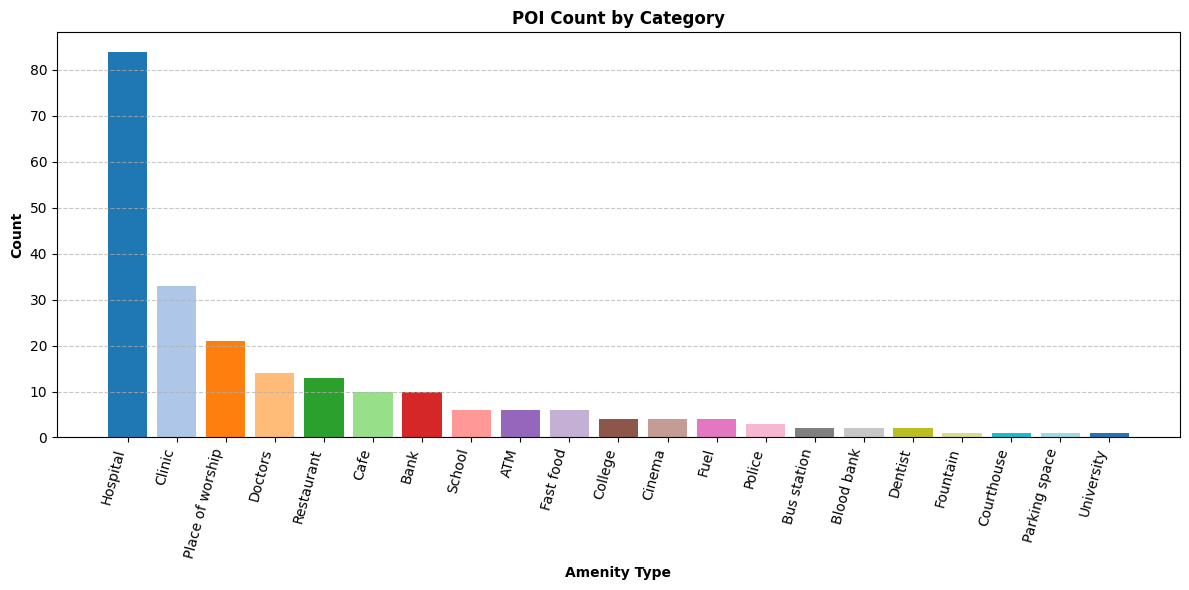

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Data extracted from the image
data = {
    'Amenity': [
        'Hospital', 'Clinic', 'Place of worship', 'Doctors', 'Restaurant', 'Cafe',
        'Bank', 'School', 'ATM', 'Fast food', 'Cinema', 'Fuel', 'College', 'Police',
        'Bus station', 'Blood bank', 'Dentist', 'Fountain', 'Courthouse',
        'Parking space', 'University'
    ],
    'Count': [
        84, 33, 21, 14, 13, 10, 10, 6, 6, 6, 4, 4, 4, 3, 2, 2, 2, 1, 1, 1, 1
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Sort by count descending
df_sorted = df.sort_values('Count', ascending=False)

# Assign different colors using a colormap
colors = plt.cm.tab20.colors  # Use tab20 for up to 20 distinct colors
bar_colors = [colors[i % len(colors)] for i in range(len(df_sorted))]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(df_sorted['Amenity'], df_sorted['Count'], color=bar_colors)
plt.xticks(rotation=75, ha='right')
plt.title('POI Count by Category',fontweight='bold')
plt.xlabel('Amenity Type',fontweight='bold')
plt.ylabel('Count',fontweight='bold')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


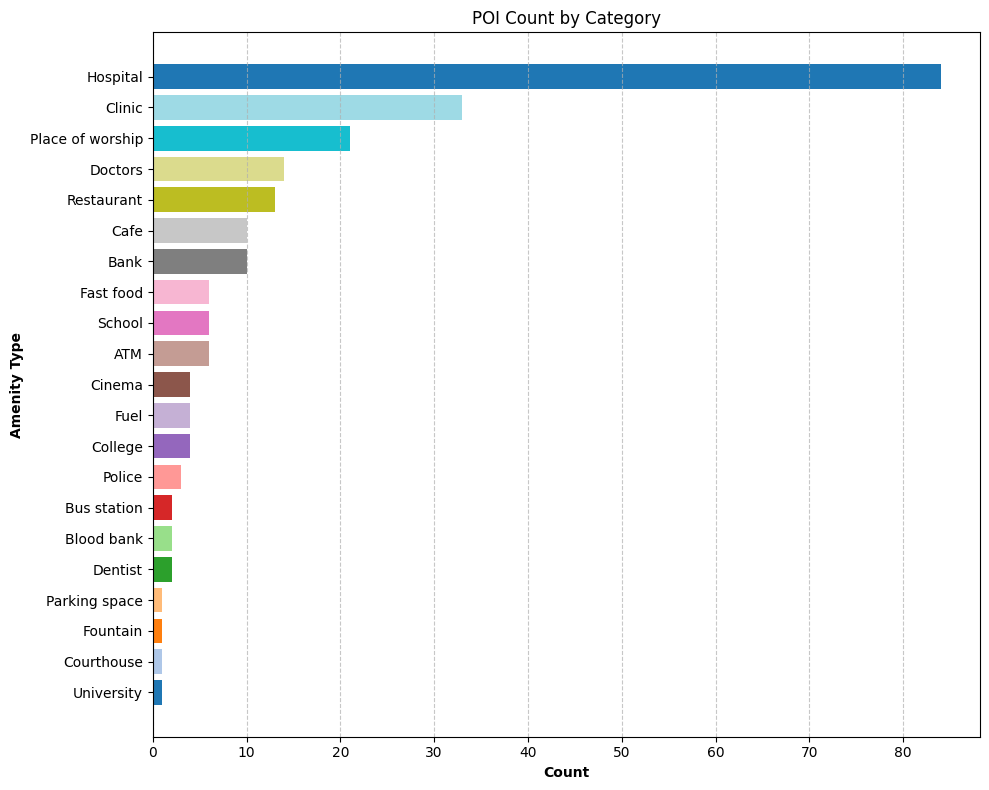

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Data extracted from the image
data = {
    'Amenity': [
        'Hospital', 'Clinic', 'Place of worship', 'Doctors', 'Restaurant', 'Cafe',
        'Bank', 'School', 'ATM', 'Fast food', 'Cinema', 'Fuel', 'College', 'Police',
        'Bus station', 'Blood bank', 'Dentist', 'Fountain', 'Courthouse',
        'Parking space', 'University'
    ],
    'Count': [
        84, 33, 21, 14, 13, 10, 10, 6, 6, 6, 4, 4, 4, 3, 2, 2, 2, 1, 1, 1, 1
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Sort by count descending
df_sorted = df.sort_values('Count', ascending=True)  # For better layout in horizontal bar chart

# Assign different colors using a colormap
colors = plt.cm.tab20.colors
bar_colors = [colors[i % len(colors)] for i in range(len(df_sorted))]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(df_sorted['Amenity'], df_sorted['Count'], color=bar_colors)
plt.xlabel('Count', fontweight='bold')
plt.ylabel('Amenity Type', fontweight='bold')
plt.title('POI Count by Category')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
